In [1]:
# Copyright 2020 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# nvTabular demo on Rossmann data

## Overview

nvTabular is a feature engineering and preprocessing library for tabular data designed to quickly and easily manipulate terabyte scale datasets used to train deep learning based recommender systems.  It provides a high level abstraction to simplify code and accelerates computation on the GPU using the RAPIDS cuDF library.


### Learning objectives

This notebook demonstrates the steps for carrying out data preprocessing, transformation and loading with NVTabular on the Kaggle Rossmann [dataset](https://www.kaggle.com/c/rossmann-store-sales/overview).  Rossmann operates over 3,000 drug stores in 7 European countries. Historical sales data for 1,115 Rossmann stores are provided. The task is to forecast the "Sales" column for the test set. 

The following example will illustrate how to use NVTabular to preprocess and load tabular data for training neural networks in both PyTorch and TensorFlow. We'll use a [dataset built by FastAI](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson3-rossman.ipynb) for solving the [Kaggle Rossmann Store Sales competition](https://www.kaggle.com/c/rossmann-store-sales). Some pandas preprocessing is required to build the appropriate feature set, so make sure to run [rossmann-store-sales-preproc.ipynb](./rossmann-store-sales-preproc.ipynb) first before going through this notebook.

In [2]:
import nvtabular as nvt
import os
import glob

/conda/envs/rapids/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/conda/envs/rapids/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_LIBDEVICE=/usr/local/cuda/nvvm/libdevice/.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))


## Preparing our dataset
Let's start by defining some of the a priori information about our data, including its schema (what columns to use and what sorts of variables they represent), as well as the location of the files corresponding to some particular sampling from this schema. Note that throughout, I'll use UPPERCASE variables to represent this sort of a priori information that you might usually encode using commandline arguments or config files.

In [3]:
DATA_DIR = os.environ.get('DATA_DIR', './data')

CATEGORICAL_COLUMNS = [
    'Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw'
]

CONTINUOUS_COLUMNS = [
    'CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday'
]
LABEL_COLUMNS = ['Sales']

COLUMNS = CATEGORICAL_COLUMNS + CONTINUOUS_COLUMNS + LABEL_COLUMNS

What files are available to train on in our data directory?

In [4]:
! ls $DATA_DIR

jp_ross  test.csv  train.csv  valid.csv


`train.csv` and `valid.csv` seem like good candidates, let's use those.

In [5]:
TRAIN_PATH = os.path.join(DATA_DIR, 'train.csv')
VALID_PATH = os.path.join(DATA_DIR, 'valid.csv')

### Workflows and Preprocessing
A `Workflow` is used to represent the chains of feature engineering and preprocessing operations performed on a dataset, and is instantiated with a description of the dataset's schema so that it can keep track of how columns transform with each operation.

In [6]:
# note that here, we want to perform a normalization transformation on the label
# column. Since NVT doesn't support transforming label columns right now, we'll
# pretend it's a regular continuous column during our feature engineering phase
proc = nvt.Workflow(
    cat_names=CATEGORICAL_COLUMNS,
    cont_names=CONTINUOUS_COLUMNS,
    label_name=LABEL_COLUMNS
)

### Ops
We add operations to a `Workflow` by leveraging the `add_(cat|cont)_feature` and `add_(cat|cont)_preprocess` methods for categorical and continuous variables, respectively. When we're done adding ops, we call the `finalize` method to let the `Workflow` build  a representation of its outputs.

In [7]:
proc.add_cont_feature(nvt.ops.FillMissing())
proc.add_cont_preprocess(nvt.ops.LogOp(columns=['Sales']))
proc.add_cont_preprocess(nvt.ops.Normalize())
proc.add_cat_preprocess(nvt.ops.Categorify())
proc.finalize()

### Datasets
In general, the `Op`s in our `Workflow` will require measurements of statistical properties of our data in order to be leveraged. For example, the `Normalize` op requires measurements of the dataset mean and standard deviation, and the `Categorify` op requires an accounting of all the categories a particular feature can manifest. However, we frequently need to measure these properties across datasets which are too large to fit into GPU memory (or CPU memory for that matter) at once.

NVTabular solves this by providing the `dataset` object, an iterator over manageable chunks of sets of parquet or csv files that can we can use to compute statistics in an online fashion (and, later, to train neural networks in batches loaded from disk). The size of those chunks will be determined by the `gpu_memory_frac` kwarg, which will load chunks whose memory footprint is equal to that fraction of available GPU memory.

Larger chunks will lead to shorter run times due to the parallel-processing power of GPUs, but will constrain your memory and possibly lead to disk caching by expensive operations, thereby lowering efficiency.

In [8]:
GPU_MEMORY_FRAC = 0.2
train_ds_iterator = nvt.dataset(TRAIN_PATH, gpu_memory_frac=GPU_MEMORY_FRAC, columns=COLUMNS)
valid_ds_iterator = nvt.dataset(VALID_PATH, gpu_memory_frac=GPU_MEMORY_FRAC, columns=COLUMNS)

Now that we have our datasets, we'll apply our `Workflow` to them and save the results out to parquet files for fast reading at train time. We'll also measure and record statistics on our training set using the `record_stats=True` kwarg so that our `Workflow` can use them at apply time.

In [9]:
PREPROCESS_DIR = os.path.join(DATA_DIR, 'jp_ross')
PREPROCESS_DIR_TRAIN = os.path.join(PREPROCESS_DIR, 'train')
PREPROCESS_DIR_VALID = os.path.join(PREPROCESS_DIR, 'valid')

! rm -rf $PREPROCESS_DIR # remove previous trials
! mkdir -p $PREPROCESS_DIR_TRAIN
! mkdir -p $PREPROCESS_DIR_VALID

In [10]:
proc.apply(train_ds_iterator, apply_offline=True, record_stats=True, output_path=PREPROCESS_DIR_TRAIN, shuffle=True, num_out_files=3)
proc.apply(valid_ds_iterator, apply_offline=True, record_stats=False, output_path=PREPROCESS_DIR_VALID, shuffle=False)

### Finalize columns
The FastAI workflow will leverage the `Workflow.ds_to_tensors` method, which will map a dataset to its corresponding PyTorch tensors. In order to make sure it runs correctly, we'll call the `create_final_cols` method to let the `Workflow` know to build the output dataset schema, and then we'll be sure to remove instances of the label column that got added to that schema when we performed processing on it.

In [11]:
proc.create_final_cols()
# using log op and normalize on sales column causes it to get added to
# continuous columns_ctx, so we'll remove it here
while True:
    try:
        proc.columns_ctx['final']['cols']['continuous'].remove(LABEL_COLUMNS[0])
    except ValueError:
        break

## Training a Network
Now that our data is preprocessed and saved out, we can leverage `dataset`s to read through the preprocessed parquet files in an online fashion to train neural networks! Even better, using the `dlpack` library, we can pass data loaded by cuDF's accelerated parquet reader to networks in TensorFlow and PyTorch in remarkably analagous ways. Let's compare them one-to-one below!

We'll start by setting some universal hyperparameters for our model and optimizer (without making any claims on the quality of these hyperparmeter choices)

In [12]:
BATCH_SIZE = 512
LEARNING_RATE = 1e-3
EMBEDDING_DROPOUT_RATE = 0.04
DROPOUT_RATES = [0.001, 0.01]
HIDDEN_DIMS = [1000, 500]
EPOCHS = 10

# our categorical encoder provides a handy utility for coming up with default embedding sizes
# based on the number of potential categories, so we'll just use those defaults
EMBEDDING_TABLE_SHAPES = {
    column: shape for column, shape in
        nvt.ops.get_embedding_size(
            proc.stats['categories'], proc.columns_ctx['categorical']['base']
        )
}

# Modify embedding size to match fast.ai rule
for col in EMBEDDING_TABLE_SHAPES:
    EMBEDDING_TABLE_SHAPES[col] = (EMBEDDING_TABLE_SHAPES[col][0], min(600, round(1.6 * EMBEDDING_TABLE_SHAPES[col][0] ** 0.56)))

TRAIN_PATHS = sorted(glob.glob(os.path.join(PREPROCESS_DIR_TRAIN, '*.parquet')))
VALID_PATHS = sorted(glob.glob(os.path.join(PREPROCESS_DIR_VALID, '*.parquet')))

In [13]:
EMBEDDING_TABLE_SHAPES

{'Assortment': (5, 4),
 'CompetitionMonthsOpen': (27, 10),
 'CompetitionOpenSinceYear': (25, 10),
 'Day': (33, 11),
 'DayOfWeek': (9, 5),
 'Events': (23, 9),
 'Month': (14, 7),
 'Promo_fw': (8, 5),
 'Promo_bw': (8, 5),
 'Promo2SinceYear': (10, 6),
 'Promo2Weeks': (28, 10),
 'PromoInterval': (5, 4),
 'SchoolHoliday_fw': (10, 6),
 'SchoolHoliday_bw': (10, 6),
 'State': (14, 7),
 'StateHoliday': (4, 3),
 'StateHoliday_fw': (5, 4),
 'StateHoliday_bw': (5, 4),
 'Store': (1117, 81),
 'StoreType': (6, 4),
 'Week': (54, 15),
 'Year': (5, 4)}

## Data Loaders
The first thing we need to do is set up the objects for getting data into our models

### Tensorflow

`KerasSequenceDataset` wraps a lightweight iterator around a `dataset` object to handle chunking, shuffling, and application of any workflows (which can be applied online as a preprocessing step). For column names, can use either a list of string names or a list of TensorFlow `feature_columns` that will be used to feed the network

In [14]:
import tensorflow as tf

# we can control how much memory to give tensorflow with this environment variable
# IMPORTANT: make sure you do this before you initialize TF's runtime, otherwise
# it's too late and TF will have claimed all free GPU memory
os.environ['TF_MEMORY_ALLOCATION'] = "8192" # explicit MB
os.environ['TF_MEMORY_ALLOCATION'] = "0.5" # fraction of free memory
from nvtabular.tf_dataloader import KerasSequenceDataset


# cheap wrapper to keep things some semblance of neat
def make_categorical_embedding_column(name, dictionary_size, embedding_dim):
    return tf.feature_column.embedding_column(
        tf.feature_column.categorical_column_with_identity(name, dictionary_size),
        embedding_dim
    )

# instantiate our columns
categorical_columns = [
    make_categorical_embedding_column(name, *EMBEDDING_TABLE_SHAPES[name]) for
        name in CATEGORICAL_COLUMNS
]
continuous_columns = [
    tf.feature_column.numeric_column(name, (1,)) for name in CONTINUOUS_COLUMNS
]

# feed them to our datasets
train_dataset_tf = KerasSequenceDataset(
    TRAIN_PATHS, # you could also use a glob pattern
    categorical_columns+continuous_columns,
    batch_size=BATCH_SIZE,
    label_name=LABEL_COLUMNS[0],
    shuffle=True,
    buffer_size=48 # how many batches to load at once
)
valid_dataset_tf = KerasSequenceDataset(
    VALID_PATHS, # you could also use a glob pattern
    categorical_columns+continuous_columns,
    batch_size=BATCH_SIZE*4,
    label_name=LABEL_COLUMNS[0],
    shuffle=False,
    buffer_size=12
)

### PyTorch
`workflow.ds_to_tensors` maps a symbolic dataset object to `cat_features`, `cont_features`, `labels` PyTorch tenosrs by iterating through the dataset and concatenating the results. Note that this means that the whole of the dataset is _in memory_. For larger than memory datasets, see the example in [criteo-example.ipynb](./criteo-example.ipynb) leveraing PyTorch `ChainDataset`s.

In [15]:
import torch
from nvtabular.torch_dataloader import TensorItrDataset, DLDataLoader
from fastai.basic_data import DataBunch
from fastai.tabular import TabularModel
from fastai.basic_train import Learner
from fastai.layers import MSELossFlat


def make_batched_dataloader(paths, columns, batch_size):
    ds_iterator = nvt.dataset(paths, columns=columns)
    ds_tensors = proc.ds_to_tensors(ds_iterator, apply_ops=False)
    ds_batch_sets = TensorItrDataset(ds_tensors, batch_size=batch_size)
    return DLDataLoader(
        ds_batch_sets,
        batch_size=None,
        pin_memory=False,
        num_workers=0
    )


train_dataset_pt = make_batched_dataloader(TRAIN_PATHS, COLUMNS, BATCH_SIZE)
valid_dataset_pt = make_batched_dataloader(VALID_PATHS, COLUMNS, BATCH_SIZE*4)
databunch = DataBunch(
    train_dataset_pt,
    valid_dataset_pt,
    collate_fn=lambda x: x,
    device="cuda"
)

/conda/envs/rapids/lib/python3.7/site-packages/cudf-0.14.0a0+4291.g6bae03d40-py3.7-linux-x86_64.egg/cudf/io/dlpack.py:74: UserWarning: WARNING: cuDF to_dlpack() produces column-major (Fortran order) output. If the output tensor needs to be row major, transpose the output of this function.
  return libdlpack.to_dlpack(gdf_cols)


## Defining a model
Next we'll need to define the inputs that will feed our model and build an architecture on top of them. For now, we'll just stick to a simple MLP model.

### Tensorflow
Using Keras, we can define the layers of our model and their parameters explicitly. Here, for the sake of consistency, I've tried to recreate the model created by FastAI as faithfully as I can given their description [here](https://docs.fast.ai/tabular.models.html#TabularModel), without making any claims as to whether this is the _right_ model to use.

In [16]:
# DenseFeatures layer needs a dictionary of {feature_name: input}
categorical_inputs = {}
for column_name in CATEGORICAL_COLUMNS:
    categorical_inputs[column_name] = tf.keras.Input(name=column_name, shape=(1,), dtype=tf.int64)
categorical_embedding_layer = tf.keras.layers.DenseFeatures(categorical_columns)
categorical_x = categorical_embedding_layer(categorical_inputs)
categorical_x = tf.keras.layers.Dropout(EMBEDDING_DROPOUT_RATE)(categorical_x)

# Just concatenating continuous, so can use a list
continuous_inputs = []
for column_name in CONTINUOUS_COLUMNS:
    continuous_inputs.append(tf.keras.Input(name=column_name, shape=(1,), dtype=tf.float32))
continuous_embedding_layer = tf.keras.layers.Concatenate(axis=1)
continuous_x = continuous_embedding_layer(continuous_inputs)
continuous_x = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.1)(continuous_x)

# concatenate and build MLP
x = tf.keras.layers.Concatenate(axis=1)([categorical_x, continuous_x])
for dim, dropout_rate in zip(HIDDEN_DIMS, DROPOUT_RATES):
    x = tf.keras.layers.Dense(dim, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(1, activation='linear')(x)

# combine all our inputs into a single list
# (note that you can still use .fit, .predict, etc. on a dict
# that maps input tensor names to input values)
inputs = list(categorical_inputs.values()) + continuous_inputs
tf_model = tf.keras.Model(inputs=inputs, outputs=x)

### PyTorch
Using FastAI's `TabularModel`, we can build an MLP under the hood by defining its high-level characteristics.

In [17]:
import pandas as pd
import numpy as np

train_df = pd.read_csv(TRAIN_PATH)
max_log_y= np.log(np.max(train_df['Sales'])*1.2)
print(max_log_y)

10.746484749743065


In [18]:
train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,1097,2,2013-01-01,5961,1405,1,0,True,1,2013,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,1.0,1.0
1,85,2,2013-01-01,4220,619,1,0,True,1,2013,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,1.0,1.0
2,259,2,2013-01-01,6851,1444,1,0,True,1,2013,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,1.0,1.0
3,262,2,2013-01-01,17267,2875,1,0,True,1,2013,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,1.0,1.0
4,274,2,2013-01-01,3102,729,1,0,True,1,2013,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803079,555,5,2015-06-19,5522,455,1,1,False,0,2015,...,15.0,57.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0
803080,419,5,2015-06-19,5996,876,1,1,False,0,2015,...,25.0,42.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0
803081,520,5,2015-06-19,4473,445,1,1,False,0,2015,...,25.0,90.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0
803082,519,5,2015-06-19,6314,596,1,1,False,0,2015,...,25.0,90.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0


In [19]:
emb_szs = [i for i in EMBEDDING_TABLE_SHAPES.values()]
print(emb_szs)

y_range = torch.tensor([0, max_log_y])

pt_model = TabularModel(
    emb_szs=emb_szs,
    n_cont=len(CONTINUOUS_COLUMNS),
    out_sz=1,
    layers=HIDDEN_DIMS,
    ps=DROPOUT_RATES,
    use_bn=True,
    emb_drop=EMBEDDING_DROPOUT_RATE,
    y_range=y_range,
)

[(5, 4), (27, 10), (25, 10), (33, 11), (9, 5), (23, 9), (14, 7), (8, 5), (8, 5), (10, 6), (28, 10), (5, 4), (10, 6), (10, 6), (14, 7), (4, 3), (5, 4), (5, 4), (1117, 81), (6, 4), (54, 15), (5, 4)]


## Define optimizer and train
This is probably the most conceptually consistent part between the frameworks: we'll define an objective and a method for optimizing it, then fit our model to our dataset iterators using that optimization scheme.

For both frameworks, we'll build a quick implementation of the metric Kaggle used in the original competition so that we can keep tabs on it during training.

### PyTorch

With the PyTorch model we will reproduce Kaggle top 10 results. Note that in RMSPE metric, Kaggle leader board top 10 is about 0.108.

In [20]:
from fastai.basic_data import DatasetType
from fastai.torch_core import flatten_check

def exp_rmspe(pred, targ):
    "Exp RMSE between `pred` and `targ`."
    pred,targ = flatten_check(pred,targ)
    pred, targ = torch.exp(pred)-1, torch.exp(targ)-1
    pct_var = (targ - pred)/targ
    return torch.sqrt((pct_var**2).mean())


learn = Learner(databunch, pt_model, metrics=[exp_rmspe])
learn.loss_func = MSELossFlat()

learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.065141,0.048554,0.253725,00:12
1,0.018261,0.022355,0.158759,00:11
2,0.013007,0.015616,0.122134,00:11
3,0.009751,0.012518,0.111562,00:11
4,0.008573,0.012136,0.109758,00:11


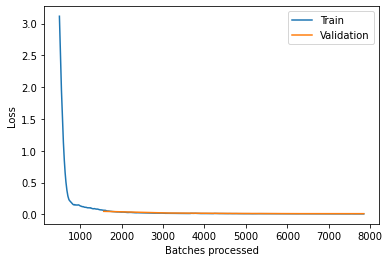

In [21]:
learn.recorder.plot_losses(skip_start=500)

In [22]:
# fine tune

learn.fit_one_cycle(5, 1e-4, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.008718,0.011836,0.110658,00:11
1,0.008631,0.011949,0.110245,00:11
2,0.008329,0.011518,0.110216,00:11
3,0.007976,0.011811,0.109495,00:12
4,0.007816,0.012121,0.109381,00:12


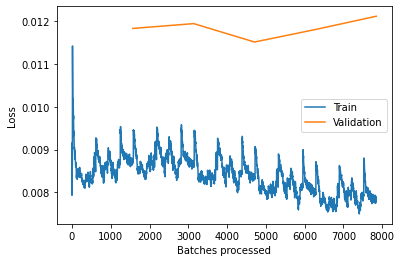

In [23]:
learn.recorder.plot_losses(skip_start=0)

### TensorFlow

In [24]:
def rmspe_tf(y_true, y_pred):
    # map back into "true" space by undoing transform
    y_true = tf.exp(y_true) - 1
    y_pred = tf.exp(y_pred) - 1

    # drop zeroes for stability (and consistency with Kaggle)
    where = tf.not_equal(y_true, 0.)
    y_true = y_true[where]
    y_pred = y_pred[where]

    percent_error = (y_true - y_pred) / y_true
    return tf.sqrt(tf.reduce_mean(percent_error**2))

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
tf_model.compile(optimizer, 'mse', metrics=[rmspe_tf])
history = tf_model.fit(
    train_dataset_tf,
    validation_data=valid_dataset_tf,
    epochs=EPOCHS
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1569 steps, validate for 21 steps
Epoch 1/10
1569/1569 [==============================] - 37s 24ms/step - loss: 3.2544 - rmspe_tf: 0.6901 - val_loss: 0.0712 - val_rmspe_tf: 0.2784
Epoch 2/10
1569/1569 [==============================] - 30s 19ms/step - loss: 0.1039 - rmspe_tf: 0.3955 - val_loss: 0.0376 - val_rmspe_tf: 0.2080
Epoch 3/10
1569/1569 [==============================] - 30s 19ms/step - loss: 0.0689 - rmspe_tf: 0.3036 - val_loss: 0.0539 - val_rmspe_tf: 0.1984
Epoch 4/10
1569/1569 [==============================] - 29s 19ms/step - loss: 0.0496 - rmspe_tf: 0.2502 - val_loss: 0.0256 - val_rmspe_tf: 0.1458
Epoch 5/10
1569/1569 [==============================] - 29s 19ms/step - loss: 0.0375 - rmspe_tf: 0.2158 - val_loss: 0.0221 - val_rmspe_tf: 0.1343
Epoch 6/10
1569/1569 [==============================] - 29s 18ms/step - loss: 0.0295 - rmspe_tf: 0.1890 - val_loss: 0.0235 - val_rmspe_tf: 0.1283
Epoch 7/10
1569/1569 [========

In [25]:
optimizer = tf.keras.optimizers.Adam(1e-4)
tf_model.compile(optimizer, 'mse', metrics=[rmspe_tf])
history = tf_model.fit(
    train_dataset_tf,
    validation_data=valid_dataset_tf,
    epochs=EPOCHS
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1569 steps, validate for 21 steps
Epoch 1/10
1569/1569 [==============================] - 35s 22ms/step - loss: 0.0141 - rmspe_tf: 0.1277 - val_loss: 0.0199 - val_rmspe_tf: 0.1323
Epoch 2/10
1569/1569 [==============================] - 29s 18ms/step - loss: 0.0137 - rmspe_tf: 0.1267 - val_loss: 0.0124 - val_rmspe_tf: 0.1130
Epoch 3/10
1569/1569 [==============================] - 29s 19ms/step - loss: 0.0135 - rmspe_tf: 0.1243 - val_loss: 0.0120 - val_rmspe_tf: 0.1118
Epoch 4/10
1569/1569 [==============================] - 29s 19ms/step - loss: 0.0132 - rmspe_tf: 0.1234 - val_loss: 0.0180 - val_rmspe_tf: 0.1154
Epoch 5/10
1569/1569 [==============================] - 29s 19ms/step - loss: 0.0130 - rmspe_tf: 0.1223 - val_loss: 0.0159 - val_rmspe_tf: 0.1210
Epoch 6/10
1569/1569 [==============================] - 29s 18ms/step - loss: 0.0128 - rmspe_tf: 0.1207 - val_loss: 0.0131 - val_rmspe_tf: 0.1136
Epoch 7/10
1569/1569 [========